In [35]:
import utils
from IPython.display import Image as DisImage
import os
import cv2
import math
import numpy as np
from scipy.ndimage.filters import maximum_filter, minimum_filter

now_path = os.path.abspath(os.getcwd())

C:\Users\CGLab_RTon\AppData\Local\Temp\ipykernel_40492\2335930660.py:7: DeprecationWarning: Please use `maximum_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import maximum_filter, minimum_filter
C:\Users\CGLab_RTon\AppData\Local\Temp\ipykernel_40492\2335930660.py:7: DeprecationWarning: Please use `minimum_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import maximum_filter, minimum_filter


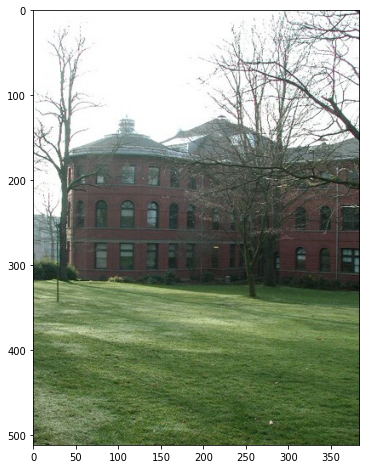

In [36]:
imgs = []
imgs.append(utils.imgImportFromPil(os.path.join(now_path, 'data/parrington/prtn00.jpg')))
# imgs.append(utils.imgImportFromPil(os.path.join(now_path, 'data/test/0test.jpg')))

utils.imshow_plt(imgs[0])

In [37]:
def to_gaussian_list(img, s = 5, sigma = 1.6, input_blur = 0.5, interval_count = 3, plt_img = False):
    height, width, _ = img.shape
    std_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    std_img = cv2.resize(std_img, (width * 2, height * 2), cv2.INTER_LINEAR)
    # σ² = σ₁² + σ₂²
    sigma_diff = math.sqrt(max(0.01, sigma ** 2 - ((input_blur * 2) ** 2)))
    # Anti alias
    std_img = cv2.GaussianBlur(std_img, (0, 0), sigmaX=sigma_diff)
    octave_count = int(math.log2(min(width, height)) - 1)
    # 2 extra LoGs because we cant scan top and bottom layers
    img_count_perOctave = s + 3
    print(octave_count)
    octaves = []
    k = 2 ** (1 / s)

    for i in range(octave_count):
        gaussian_imgs = []
        gaussian_imgs.append(cv2.GaussianBlur(std_img, (0, 0), sigmaX=sigma))
        # octave
        for j in range(1, img_count_perOctave):
            gaussian_imgs.append(cv2.GaussianBlur(std_img, (0, 0), sigmaX=(sigma * (k ** j))))
            print("Sigma:", sigma * (k ** j))
        DoGs = []
        for j in range(img_count_perOctave - 1):
            # DoGs.append(cv2.subtract(gaussian_imgs[j], gaussian_imgs[j + 1]))
            DoGs.append(gaussian_imgs[j].astype('float32') - gaussian_imgs[j + 1].astype('float32'))
        octaves.append(DoGs)
        # scale down image to speed up process
        std_img = cv2.resize(gaussian_imgs[-3], (width // (2 ** i), height // (2 ** i)))
        # sigma *= 2
        if plt_img:
            utils.imshows_plt(gaussian_imgs)
            utils.imshows_plt(DoGs)
        
    return octaves
    

In [38]:
# to_gaussian_list(imgs[0], plt_img=True)

In [39]:
# def findMaxAndMinIn3x3x3(DoGs, DoGId, row, col):
#     for i in ra
#     maxVal = max(DoGs[DoGId][row][col], DoGs[DoGId][row][col], DoGs[DoGId][row][col])


In [40]:
octave_dogs = to_gaussian_list(imgs[0])

7
Sigma: 1.8379173679952563
Sigma: 2.111212657236631
Sigma: 2.4251465064166378
Sigma: 2.7857618025475985
Sigma: 3.2000000000000015
Sigma: 3.675834735990514
Sigma: 4.222425314473265
Sigma: 1.8379173679952563
Sigma: 2.111212657236631
Sigma: 2.4251465064166378
Sigma: 2.7857618025475985
Sigma: 3.2000000000000015
Sigma: 3.675834735990514
Sigma: 4.222425314473265
Sigma: 1.8379173679952563
Sigma: 2.111212657236631
Sigma: 2.4251465064166378
Sigma: 2.7857618025475985
Sigma: 3.2000000000000015
Sigma: 3.675834735990514
Sigma: 4.222425314473265
Sigma: 1.8379173679952563
Sigma: 2.111212657236631
Sigma: 2.4251465064166378
Sigma: 2.7857618025475985
Sigma: 3.2000000000000015
Sigma: 3.675834735990514
Sigma: 4.222425314473265
Sigma: 1.8379173679952563
Sigma: 2.111212657236631
Sigma: 2.4251465064166378
Sigma: 2.7857618025475985
Sigma: 3.2000000000000015
Sigma: 3.675834735990514
Sigma: 4.222425314473265
Sigma: 1.8379173679952563
Sigma: 2.111212657236631
Sigma: 2.4251465064166378
Sigma: 2.7857618025475985


In [41]:
def findExtremaInDoG(DoGOctaves, scale = 1, OctaveLayersCount = 5, contrastThreshold = 0.4):
    # height, width = DoGs[0].shape
    for DoGIdx in range(len(DoGOctaves)):
        maxConv = DoGOctaves[DoGIdx]*(DoGOctaves[DoGIdx] == maximum_filter(DoGOctaves[DoGIdx],footprint=np.ones((3,3,3))))
        minConv = DoGOctaves[DoGIdx]*(DoGOctaves[DoGIdx] == minimum_filter(DoGOctaves[DoGIdx],footprint=np.ones((3,3,3))))

        utils.imshow_plt(maxConv[0])
        threshold = int(0.5 * contrastThreshold / (OctaveLayersCount + 3) * 255)
        maxConvInds = np.argwhere(maxConv > threshold)
        minConvInds = np.argwhere(minConv < -threshold)

        print("Max len:", len(maxConvInds))
        print("min len:", len(minConvInds))

        print(np.array(maxConvInds))

        candidates = []
        candidates.extend(maxConvInds)
        candidates.extend(minConvInds)

    print("Extrema length:", len(candidates), candidates[0])

    keypoints = []
    keypoint_dict = {}
    for candidate in candidates:
        # if candidate[0] == 0:
        if (candidate[2], candidate[1]) not in keypoint_dict:
            # keypoints.append(cv2.KeyPoint(float(candidate[2]), float(candidate[1]), 1))
            keypoints.append(float(candidate[1]), float(candidate[2]), scale)
            keypoint_dict[(candidate[2], candidate[1])] = 1
                # keypoints.append([candidate[1], candidate[2]])
    print(len(keypoint_dict))
    return keypoints

    

    
    

In [ ]:
def ExtremumQuadFit(D, row, col, scale):
    dx = (D[scale][row, col + 1] - D[scale][row, col - 1]) / 2
    dy = (D[scale][row + 1, col] - D[scale][row - 1, col]) / 2
    ds = (D[scale + 1][row, col] - D[scale - 1][row, col]) / 2

    # dxx = 
    

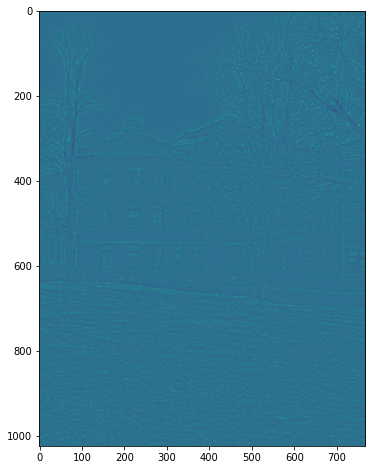

Max len: 437
min len: 857
[[  0 201 643]
 [  1   0 767]
 [  1 220 696]
 ...
 [  6 484  60]
 [  6 970 558]
 [  6 972 558]]
Extrema length: 1294 [  0 201 643]
971


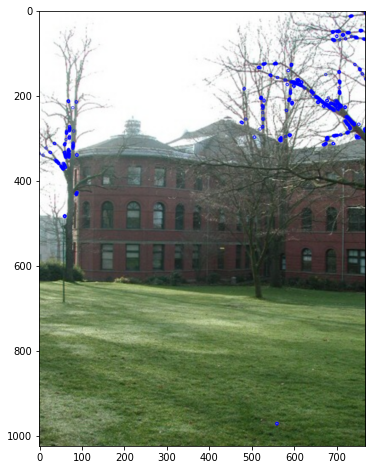

In [42]:
keypoints = findExtremaInDoG(octave_dogs[0])


im_key = cv2.drawKeypoints(cv2.resize(imgs[0], (imgs[0].shape[1] * 2, imgs[0].shape[0] * 2)), keypoints, np.array([]), (255, 0, 0))

utils.imshow_plt(im_key)

In [43]:
print()